In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds 
%tensorflow_version 2.x
from tensorflow import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import Dropout,Concatenate,LSTM, Bidirectional
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU,ReLU
from keras.layers.convolutional import UpSampling2D,UpSampling1D, Conv2D ,Conv1DTranspose, Conv2DTranspose,Conv1D
from keras.models import Sequential, Model
import tensorflow.keras.optimizers as ko
import matplotlib.pyplot as plt
Adam = ko.Adam
from tqdm import tqdm

import sys,os
import numpy as np
import scipy as sc
import soundfile as sf

In [ ]:
types=["bass",
"brass",
"flute",
"guitar",
"keyboard",
"mallet",
"organ",
"reed",
"string",
"synth_lead",
"vocal"]

In [ ]:
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [ ]:
import pickle

# structure of files 
#   |- path
#     |- train.dat

# the root path from Drive
path = "/content/drive/MyDrive/Colab Notebooks/Exp3_Gans/"
from google.colab import drive
drive.mount('/content/drive')

# Data Prep

In [ ]:
import warnings
import librosa
import IPython.display as ipd
from librosa import display as libdis


from matplotlib import pyplot as plt

## Fetch dataset and process

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  # ds = ds.batch(32)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

# Used for sepreate specified quaility data from dataset
quality = [0,1,0,0,0,0,0,0,0,0] 

(train_ds, val_ds, test_ds), metadata = tfds.load(
    'nsynth/gansynth_subset.f0_and_loudness',
    split=['train[:100%]', 'valid[:100%]', 'test[:100%]'],
    with_info=True,
    try_gcs=True
)

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

x_train=[]
with strategy.scope():
  
# ==============================================
# Get all satistified data from all three dataset
# =============================================== 

  total = len(train_ds)+len(val_ds)+len(test_ds)
  with tqdm(total=total) as progress_bar:
    for i in train_ds.as_numpy_iterator():
      if(list(i["qualities"].values())== quality):
        x_train.append(i)
      progress_bar.update()

    for i in val_ds.as_numpy_iterator():
      if(list(i["qualities"].values())== quality):
        x_train.append(i)
      progress_bar.update()

    for i in test_ds.as_numpy_iterator():
      if(list(i["qualities"].values())== quality):
        x_train.append(i)
      progress_bar.update()

x_train=np.array(x_train)

# Save all data into file:

with open(path+"train.dat","wb") as f:
  pickle.dump(x_train,f)

# ==============================================
# OR, pull prepared data from Drive
# ===============================================
  # import pickle

  # path = "/content/drive/MyDrive/Colab Notebooks/Exp3_Gans/"
  # from google.colab import drive
  # drive.mount('/content/drive')

  # with open(path+"train.dat","rb") as f:
  #   x_train=pickle.load(f)


Mounted at /content/drive


In [ ]:
x_train.shape

(2715,)

## Metadata

In [ ]:
metadata

tfds.core.DatasetInfo(
    name='nsynth',
    version=2.3.3,
    description='The NSynth Dataset is an audio dataset containing ~300k musical notes, each
with a unique pitch, timbre, and envelope. Each note is annotated with three
additional pieces of information based on a combination of human evaluation
and heuristic algorithms: Source, Family, and Qualities.',
    homepage='https://g.co/magenta/nsynth-dataset',
    features=FeaturesDict({
        'audio': Audio(shape=(64000,), dtype=tf.float32),
        'f0': FeaturesDict({
            'confidence': Tensor(shape=(1000,), dtype=tf.float32),
            'hz': Tensor(shape=(1000,), dtype=tf.float32),
            'midi': Tensor(shape=(1000,), dtype=tf.float32),
        }),
        'id': tf.string,
        'instrument': FeaturesDict({
            'family': ClassLabel(shape=(), dtype=tf.int64, num_classes=11),
            'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=1006),
            'source': ClassLabel(shape=(), dtype=tf.i

## Generate lables


In [ ]:
# insts=np.array(range(11))
y_train = np.array([np.zeros((11,)) for i in range(len(x_train))])
for i,x in enumerate(tqdm(x_train)):
  la= x['instrument']['family']
  y_train[i][la]=1
y_train[:40]

100%|██████████| 2715/2715 [00:00<00:00, 735581.38it/s]


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.

## Display examples

mallet
b'mallet_acoustic_054-065-075'


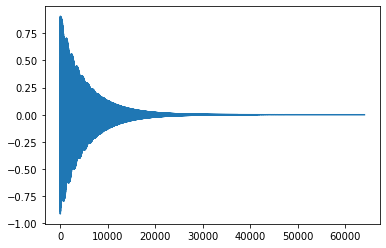

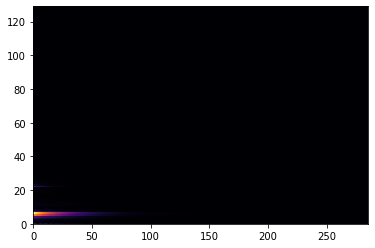

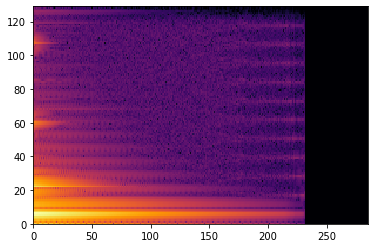

In [ ]:
from numpy import random
a = x_train[np.random.randint(len(x_train))]
print(types[a['instrument']['family']])
print(a['id'])
a=a['audio']
# spec = librosa.feature.melspectrogram(a,n_fft=256)
f,t,spec = sc.signal.spectrogram(a,mode='magnitude',nfft=256)
# s_db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)[:1024][:]
S_dB = librosa.power_to_db(spec, ref=np.max)
inv_s=librosa.core.spectrum.griffinlim(spec)
ipd.display(ipd.Audio(a,rate=44100))
ipd.display(ipd.Audio(inv_s,rate=44100))
plt.figure()
# librosa.display.specshow(s_db)
# plt.pcolormesh(spec,cmap="inferno")
plt.plot(a)
plt.show()
plt.pcolormesh(spec,cmap="inferno")
plt.show()
plt.pcolormesh(S_dB,cmap="inferno")
plt.show()
# img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=44100)
# print(img)
# plt.colorbar(img)
# plt.colorbar()
# ipd.Audio(a,rate=44100)
# s_db.shape

# inv_s=librosa.feature.inverse.mel_to_audio(spec)
# ipd.Audio(inv_s,rate=44100)
# np.min(spec),np.max(spec)

## Take only audio(wave) into training

In [ ]:
size = len(x_train)
# f, t, test_spec = sc.signal.stft(x_train[0], fs=44100)
# test_spec = librosa.feature.melspectrogram(x_train[0]['audio'])
test_x = x_train[0]['audio']
# test_spec = librosa.stft(test)
xs = np.ndarray((size,test_x.shape[0]),dtype=np.complex64)
with strategy.scope():
  for i in tqdm(range(size)):
    # x_ = librosa.feature.melspectrogram(x_train[i]['audio'])
    x_ = x_train[i]['audio']
    # db = librosa.amplitude_to_db(np.abs(spec), ref=np.max)[:1024][:]
    xs[i] = x_

100%|██████████| 2715/2715 [00:00<00:00, 7266.30it/s]


In [ ]:
xs.shape

(2715, 64000)

# Model

In [ ]:
class GAN():
    def __init__(self):
        self.img_rows = 64000
        self.channels = 1
        self.img_shape = (self.img_rows, self.channels)
        self.latent_dim = 100
        self.kernal_size = 25
        

        optimizer = Adam(0.00002, 0.5)
        optimizer_discriminator = Adam(0.00002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer_discriminator,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        cond_disc = Input(shape=(11,))
        cond_gen = Input(shape=(11,))
        img = self.generator([z,cond_gen])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator([img,cond_disc])

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([z,cond_gen,cond_disc], validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    # phase Shuffel
    
    def phaseShuffle(self,layer,rad=2):
      x_shape=layer.shape
      phase = tf.random.uniform([], minval=-rad, maxval=rad + 1, dtype=tf.int32)
      pad_l = tf.maximum(phase, 0)
      pad_r = tf.maximum(-phase, 0)
      phase_start = pad_r
      layer = tf.pad(layer, [[0, 0], [pad_l, pad_r], [0, 0]], mode='reflect')
      layer = layer[:, phase_start:phase_start+x_shape[1]]
      # layer.reshape(x_shape)
      return layer

    def Conv1DBlock(self,layer,kernal_size=3,strides=2, channel_num=128):
      layer = Conv1DTranspose(channel_num,kernal_size,strides=strides,padding="same")(layer)
      layer = BatchNormalization(momentum=0.9)(layer)
      layer = ReLU()(layer)#LeakyReLU(alpha=0.1)(layer) # 32 14
      
      # layer = Conv1D(channel_num,kernal_size,padding="same")(layer)
      # #layer = BatchNormalization(momentum=0.9)(layer)
      # layer = LeakyReLU(alpha=0.1)(layer)

      # layer = Conv1D(channel_num,kernal_size,padding="same")(layer)
      # #layer = BatchNormalization(momentum=0.9)(layer)
      # layer = LeakyReLU(alpha=0.1)(layer)

      return layer

    def UpsampleBlock(self,layer,size=2,kernal_size=3,channel_num=128):
      layer = UpSampling1D(size)(layer)
      layer = BatchNormalization(momentum=0.9)(layer)
      layer = LeakyReLU(alpha=0.1)(layer) # 32 14
      
      layer = Conv1D(channel_num,kernal_size,padding="same")(layer)
      layer = BatchNormalization(momentum=0.9)(layer)
      layer = LeakyReLU(alpha=0.1)(layer)

      layer = Conv1D(channel_num,kernal_size,padding="same")(layer)
      layer = BatchNormalization(momentum=0.9)(layer)
      layer = LeakyReLU(alpha=0.1)(layer)

      return layer

    def disc_Conv1DBlock(self,layer,kernal_size=3,strides=1, channel_num=128):
      layer = Conv1D(channel_num,self.kernal_size,strides=strides,padding="same")(layer)
      # layer = BatchNormalization(momentum=0.9)(layer)
      layer = LeakyReLU(alpha=0.2)(layer)
      layer = Dropout(0.25)(layer)
      layer = self.phaseShuffle(layer,rad=2)

      return layer

    def build_generator(self):
        #shape 128, 126
        inputx = Input(shape=(self.latent_dim,))
        inputy = Input(shape=(11,))

        layer = Concatenate()([inputx,inputy])
        layer = Dense(256)(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = ReLU()(layer)

        layer = Reshape((1,256))(layer)

        layer = Conv1DTranspose(256,1,strides=125,padding="same")(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = ReLU()(layer)#LeakyReLU(alpha=0.1)(layer)

        # layer = Bidirectional(LSTM(128,activation='relu',return_sequences=True,recurrent_dropout=0.2))(layer)
        # layer = Bidirectional(LSTM(128,activation='relu',return_sequences=True,recurrent_dropout=0.2))(layer)

        # layer = Conv1D(128,self.kernal_size,padding="same")(layer)
        # layer = BatchNormalization(momentum=0.9)(layer)
        # layer = ReLU()(layer)

        for t in range(4):
          ch_num=128//(2**t)
          layer = self.Conv1DBlock(layer,kernal_size=self.kernal_size,
                        strides=4,
                        channel_num=ch_num)  
        
        # layer = self.Conv1DBlock(layer,kernal_size=self.kernal_size,
        #                 strides=2,
        #                 channel_num=16)
        layer = Conv1DTranspose(1,self.kernal_size,strides=2,padding="same")(layer)
        #layer = BatchNormalization(momentum=0.9)(layer)
        

        # layer = Conv1D(self.channels,self.kernal_size,strides=1,padding="same")(layer) 
        # out = Activation("sigmoid")(layer)
        out = Activation("tanh")(layer)
        # out = Activation("linear")(layer)
        model = Model(inputs=[inputx,inputy], outputs=out, name="Generator")
        model.summary()

        return model

    def build_discriminator(self):

        inputx = Input(shape=self.img_shape)
        inputy = Input(shape=(11,))

        layer = self.disc_Conv1DBlock(inputx,
                                  kernal_size=self.kernal_size,
                                  strides=5,
                                  channel_num=128)

        for i in range(3): 
          layer = self.disc_Conv1DBlock(layer,
                                  kernal_size=self.kernal_size,
                                  strides=5,
                                  channel_num=128)
          
        layer = Flatten()(layer)
        layer = Concatenate()([layer,inputy])

        layer = Dense(1024)(layer)
        layer = LeakyReLU(alpha=0.2)(layer) 
        layer = Dropout(0.5)(layer)

        out = Dense(1, activation='sigmoid')(layer)

        model = Model(inputs=[inputx,inputy],outputs=out,name="Discriminator")
        model.summary()

        return model
    def one_hot_encode(self, y):
      z=np.zeros((len(y),11))
      idx=np.arange(len(y))
      z[idx,y]=1
      return z
    def generate_random_label(self,n): #n is batch size
      y=np.random.choice(11,n)
      y=self.one_hot_encode(y)
      return y

    def train(self, X_train,Y_train, epochs, batch_size=128, sample_interval=50,res_interval=20):

        X_train = X_train.reshape((X_train.shape[0],self.img_rows,self.channels))

        print(X_train.shape)
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        self.epochs = epochs

        num_batches = int(X_train.shape[0]/batch_size)

        # pbar = tqdm(range(epochs))
        for epoch in range(epochs):
            pbar_batch = tqdm(range(num_batches))
            sum_G_loss=0 
            sum_D_loss=0 
            sum_acc=0 
            for batch_idx in pbar_batch:
              # ---------------------
              #  Train Discriminator
              # ---------------------

              # Select a random batch of images
              # idx = np.random.randint(0, X_train.shape[0], batch_size)
              imgs = X_train[batch_idx*batch_size : (batch_idx+1)*batch_size]
               
              self.labels = Y_train[batch_idx*batch_size : (batch_idx+1)*batch_size]
              
              # noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
              noise = np.random.uniform(-1, 1, (batch_size, self.latent_dim))

              # Generate a batch of new images
              gen_imgs = self.generator.predict([noise,self.labels])

              # Train the discriminator
              if epoch % 1 ==0:
                d_loss_real = self.discriminator.train_on_batch([imgs,self.labels], valid)
                d_loss_fake = self.discriminator.train_on_batch([gen_imgs,self.labels], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
              else:
                d_loss=[0,0]

              # ---------------------
              #  Train Generator
              # ---------------------
              random_labels= self.generate_random_label(batch_size)
              # noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
              noise = np.random.uniform(-1, 1, (batch_size, self.latent_dim))

              # Train the generator (to have the discriminator label samples as valid)
              g_loss = self.combined.train_on_batch([noise,random_labels,random_labels], valid)

              sum_G_loss+=g_loss
              sum_D_loss+=d_loss[0]
              sum_acc+=d_loss[1]

              avg_g = sum_G_loss/(batch_idx+1)
              avg_d = sum_D_loss/(batch_idx+1)
              avg_acc = sum_acc/(batch_idx+1)
              # Plot the progress
              # print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
              # pbar_batch.set_description("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
              pbar_batch.set_description("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, avg_d, 100*avg_acc, avg_g))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
            if epoch % res_interval == 0:
                self.gen_result(epoch)

    def sample_images(self, epoch):
      r, c = 5, 5
      noise = np.random.uniform(-1, 1, (r * c, self.latent_dim))
      gen_imgs = self.generator.predict([noise,self.labels[:25]])

      fig, axs = plt.subplots(r, c)
      fig2, axs2 = plt.subplots(r, c)
      cnt = 0
      for i in range(r):
          for j in range(c):
              simg = gen_imgs[cnt, :,0]
              _,_,spec = sc.signal.spectrogram(simg,mode='magnitude',nfft=256)
              axs[i,j].pcolormesh(spec,cmap="inferno")
              axs2[i,j].plot(simg)
              axs[i,j].axis('off')
              axs2[i,j].axis('off')
              cnt += 1
      
      fn = str(epoch).zfill(len(str(self.epochs)))
      fig.savefig("/content/sample/%s-spec.png" % fn)
      plt.close(fig)
      fig2.savefig("/content/sample/%s-wave.png" % fn)
      plt.close(fig2)

    def gen_result(self,epoch):
      noise = np.random.uniform(-1, 1, self.latent_dim)
      l = [[0,0,0,0,0,0,0,0,0,0,0]]
      rdir = "/content/result/"+str(epoch).zfill(len(str(self.epochs)))
      os.mkdir(rdir)
      for i in range(len(types)):
        l[0][i]=1
        # print([noise,l])
        tn = types[i]
        td = rdir+"/"+tn+"/"
        os.mkdir(td)
        gen_imgs = self.generator.predict([
                            noise.reshape(1,self.latent_dim),
                            np.array(l,dtype=np.float32)]).reshape((64000,))
        fn = str(epoch).zfill(len(str(self.epochs)))
        _,_,spec = sc.signal.spectrogram(gen_imgs,mode='magnitude',nfft=256)
        fig = plt.figure()
        ax = fig.gca()
        ax.axis('off')
        ax.pcolormesh(spec,cmap="inferno")
        fig.savefig(td+"%s(%s)-spec.png" % (fn,tn))
        plt.close(fig)
        fig = plt.figure()
        ax = fig.gca()
        ax.axis('off')
        ax.plot(gen_imgs)
        fig.savefig(td+"%s(%s)-wave.png" % (fn,tn))
        plt.close(fig)
        sf.write(td+"%s(%s).wav" % (fn,tn),gen_imgs,44100)


gan = GAN() 

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_61 (InputLayer)          [(None, 64000, 1)]   0           []                               
                                                                                                  
 conv1d_40 (Conv1D)             (None, 12800, 128)   3328        ['input_61[0][0]']               
                                                                                                  
 leaky_re_lu_45 (LeakyReLU)     (None, 12800, 128)   0           ['conv1d_40[0][0]']              
                                                                                                  
 dropout_45 (Dropout)           (None, 12800, 128)   0           ['leaky_re_lu_45[0][0]']         
                                                                                      

# Train

In [ ]:
!rm -rf "/content/sample/"
!mkdir "/content/sample/"

!rm -rf "/content/result/"
!mkdir "/content/result/"

with strategy.scope():
  gan.train(xs,y_train[:size], epochs=10, batch_size=64, sample_interval=1,res_interval=1)


(2715, 64000, 1)


0 [D loss: 0.413993, acc.: 72.75%] [G loss: 0.699883]: 100%|██████████| 42/42 [00:30<00:00,  1.39it/s]
1 [D loss: 0.067793, acc.: 99.07%] [G loss: 3.453980]: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
2 [D loss: 0.013877, acc.: 99.67%] [G loss: 5.111648]: 100%|██████████| 42/42 [00:25<00:00,  1.62it/s]
3 [D loss: 0.005625, acc.: 99.83%] [G loss: 5.803163]: 100%|██████████| 42/42 [00:25<00:00,  1.65it/s]
4 [D loss: 0.004894, acc.: 99.87%] [G loss: 5.687075]:  43%|████▎     | 18/42 [00:11<00:14,  1.61it/s]


KeyboardInterrupt: ignored

# Result 

mallet


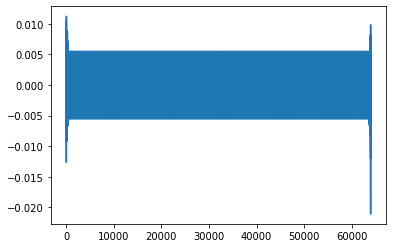

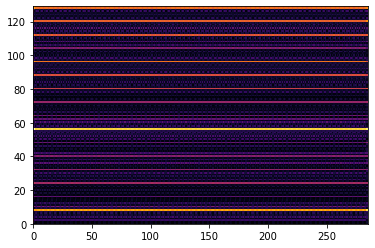

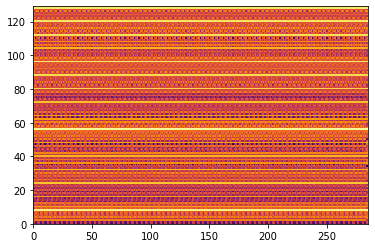

[-0.00500045  0.01057993  0.00425464 ... -0.01720972 -0.00464089
 -0.01030016] 0.011220795 -0.021071466


In [ ]:
!rm -rf "out/"
!mkdir "out/"

# k=np.random.normal(0,1,gan.latent_dim)
k=np.random.uniform(-1,1,gan.latent_dim)
rl = random.randint(11)
test = -1
test_label = [[0,0,0,0,0,0,0,0,0,0,0]]
if test >=0:
  test_label[0][test]=1
  print(types[test])
else:
  test_label[0][rl] = 1 
  print(types[rl])
imgg=gan.generator.predict([k.reshape(1,gan.latent_dim),
                            np.array(test_label,dtype=np.float32)])\
                            .reshape((64000,))
ipd.display(ipd.Audio(imgg,rate=44100))
# imgg=np.log(imgg/(1-imgg))
# plt.imshow(imgg, cmap="gray")
# plt.pcolormesh(t, f, np.abs(imgg))
# spec = librosa.feature.melspectrogram(imgg,n_fft=256)
_,_,spec = sc.signal.spectrogram(imgg,mode='magnitude',nfft=256)
sdb = librosa.power_to_db(spec, ref=np.max)
plt.plot(imgg)
# plt.imsave("out/wave.png",imgg)
plt.show()
plt.pcolormesh(spec,cmap="inferno")
plt.savefig("out/spec.png")
plt.show()
plt.pcolormesh(sdb,cmap="inferno")
plt.savefig("out/spec_db.png")
plt.show()
# plt.specgram(imgg)
# inv_s=librosa.griffinlim(imgg)
# ipd.Audio(inv_s,rate=44100)
sf.write("out/out.wav",imgg,44100)
print(imgg,np.max(imgg),np.min(imgg)) 

# !zip "res.zip" "out/*"